<a href="https://colab.research.google.com/github/gaixen/Frames-to-Fables_assignment01/blob/main/Task%202/dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance transformers torch textblob pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [21]:
with open("/content/ticker_symbols.txt", "r") as f:
    ticker_line = f.read()
tickers = [ticker.strip() for ticker in ticker_line.split(',')]
tickers[:5]

['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']

In [22]:
import yfinance as yf
import pandas as pd
financial_data = []#initialise
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        company_name = info.get("longName", "N/A")
        revenue = info.get("totalRevenue", 0)
        net_income = info.get("netIncomeToCommon", 0)
        eps = info.get("trailingEps", 0)
        financial_data.append({
            "Company_name": company_name,
            "Ticker_symbol": ticker,
            "Revenue": revenue,
            "Net_income": net_income,
            "EPS": eps,
            "Earnings_call_summary": "",
            "Sentiment_score": None
        })
#debugging step
    except Exception as e:
        print(f"Error retrieving {ticker}: {e}")

In [23]:
#These are some call summaries based on company earning
summaries = {
    "AAPL": "Strong iPhone 15 sales; services division saw record revenue; focus on AI integration.",
    "MSFT": "Azure growth strong; AI tools like Copilot widely adopted; cloud demand remains high.",
    "AMZN": "AWS revenue stabilized; focus on cost-cutting; AI investments in retail efficiency.",
    "GOOGL": "Search and YouTube ad growth returned; Gemini AI launched; cloud turning profitable.",
    "META": "Strong ad performance; Reality Labs losses widen; AI recommendations improved.",
    "TSLA": "Margins impacted due to price cuts; Cybertruck production under way; energy storage up.",
    "NVDA": "Record GPU sales driven by AI demand; strong data center growth; gaming stable.",
    "BRK.B": "Insurance profits rose; Apple remains top holding; record cash reserves; disciplined M&A.",
    "JPM": "Strong investment banking fees; credit losses stable; cautious macroeconomic outlook.",
    "JNJ": "Pharma sales steady; MedTech devices grew; consumer spin-off Kenvue completed.",
    "PG": "Price hikes boosted sales; strong growth in fabric and home care; volume slightly down.",
    "V": "Payment volumes increased; travel-related spend high; digital wallet partnerships expanded.",
    "MA": "Cross-border volumes rose; AI used in fraud detection; healthy consumer spending observed.",
    "WMT": "E-commerce and groceries grew; cautious consumer sentiment noted; automation investment.",
    "HD": "Professional customer sales rose; home improvement demand softened slightly post-COVID boom.",
    "XOM": "Refining margins high; renewable projects scaling; cautious capex despite oil profits.",
    "CVX": "Strong upstream profits; LNG demand rising; Permian Basin output increased.",
    "KO": "Volume flat but price mix favorable; growth in zero-sugar drinks; FX headwinds remain.",
    "PEP": "Snacks division grew rapidly; beverage margins improved; resilient global demand.",
    "MCD": "Same-store sales up; digital channels expanded; cost inflation partially offset.",
    "DIS": "Streaming losses narrowed; Disney+ subscribers grew; linear TV continues to decline.",
    "NFLX": "Password-sharing crackdown drove user growth; ad tier expanded; content spending stable.",
    "INTC": "Foundry business separated; weak PC demand offset by AI chip push; cautious guidance.",
    "AMD": "Data center and AI chips gained momentum; gaming revenue flat; guidance raised.",
    "ADBE": "Creative Cloud subscriptions strong; Firefly AI tools integrated; ARR growth solid.",
    "CRM": "Margins improved; AI features launched in Salesforce Cloud; customer retention high.",
    "BA": "Aircraft deliveries rose; defense business under pressure; production delays continue.",
    "NKE": "DTC sales rose; China recovery solid; inventory management improving post-surge.",
    "VZ": "5G subscriber growth steady; revenue stable; focus on cost cuts and rural rollout.",
    "T": "Wireless revenue solid; broadband additions grew; debt reduction remains a focus."
}
for row in financial_data:
    ticker = row["Ticker_symbol"]
    row["Earnings_call_summary"] = summaries.get(ticker, "Summary not available.")


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

def get_sentiment_score(text):
    sentences = text.split('.')
    scores = []
    for sent in sentences:
        sent = sent.strip()
        if sent:
            inputs = sentiment_tokenizer(sent, return_tensors="pt", truncation=True,max_length=128)
            outputs = sentiment_model(**inputs)
            probs = softmax(outputs.logits.detach().numpy()[0])
            score = probs[2] - probs[0]  # Positive - Negative
            scores.append(score)
    return round(sum(scores), 3)
#add sentiment scores to the dataset
for row in financial_data:
    row["Sentiment_score"] = get_sentiment_score(row["Earnings_call_summary"])

In [29]:
df = pd.DataFrame(financial_data)
df.to_csv("/content/market_dataset.csv", index=False)
df.head()

,Company_name,Ticker_symbol,Revenue,Net_income,EPS,Earnings_call_summary,Sentiment_score
0,Apple Inc.,AAPL,400366010368,97294000128,6.41,Strong iPhone 15 sales; services division saw ...,0.930
1,Microsoft Corporation,MSFT,270010007552,96635002880,12.92,Azure growth strong; AI tools like Copilot wid...,0.894
2,"Amazon.com, Inc.",AMZN,650313007104,65943998464,6.14,AWS revenue stabilized; focus on cost-cutting;...,0.586
3,Alphabet Inc.,GOOGL,359713013760,110995996672,8.95,Search and YouTube ad growth returned; Gemini ...,0.830
4,"Meta Platforms, Inc.",META,170359996416,66635001856,25.61,Strong ad performance; Reality Labs losses wid...,0.673


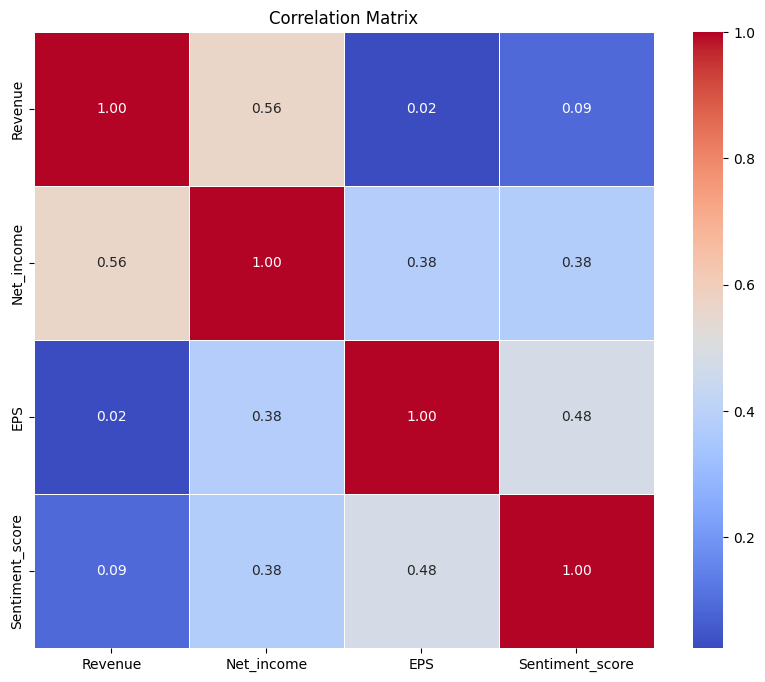

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
df_numeric = df[['Revenue', 'Net_income', 'EPS', 'Sentiment_score']]
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()
